In [1]:
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Hyperparameters

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = False

# Hyperparameters
FOLDS = 21 if PRODUCTION else 2   # Only 5 or 10.
EPOCHS = 121        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'selu' # swish mish relu selu ;swish seem to work better with binary classification only?
KERNEL_INIT = "lecun_normal" # Minimal impact, but give your init the right foot forward glorot_uniform
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.7   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 19  # Early stopping
DROPOUT = 0.1     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [192, 128, 128, 64]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 11426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"            # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

# Misc functions

In [3]:
def plot_acc(history_f):
    fold = 0
    best_epoch = np.argmin(np.array(history_f['val_loss']))
    best_val_loss = history_f['val_loss'][best_epoch]

    fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

    fig.suptitle('Fold : '+ str(fold+1) +
                 " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                 " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                 " LR: {:0.8f}".format(history_f['lr'].min())
                 , fontsize=14)

    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])

    from_epoch = 0
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
    if best_epoch > 0:
        almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
        almost_val_loss = history_f['val_loss'][almost_epoch]
        if almost_epoch >= from_epoch:
            plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')   

    ax2 = plt.gca().twinx()
    ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
    ax2.set_ylabel('Learning rate')
    ax2.legend(loc = 'upper right')
    ax2.grid()

    best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
    best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]

    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower left')
    plt.legend(fontsize = 15)
    plt.grid(b = True, linestyle = '-')


# Load dataset

In [4]:
# load the dataset
def load_dataset():
    return make_classification(
        n_samples=10000,
        n_features=15,
        n_informative=3,
        n_redundant=2,
        n_repeated=0,
        n_classes=8,
        n_clusters_per_class=1,
        random_state=RANDOM_STATE,
    )

X, y = load_dataset()

# Plot

C:\Users\furyx\miniconda3\envs\tf27\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Two informative features, one cluster per class'}>

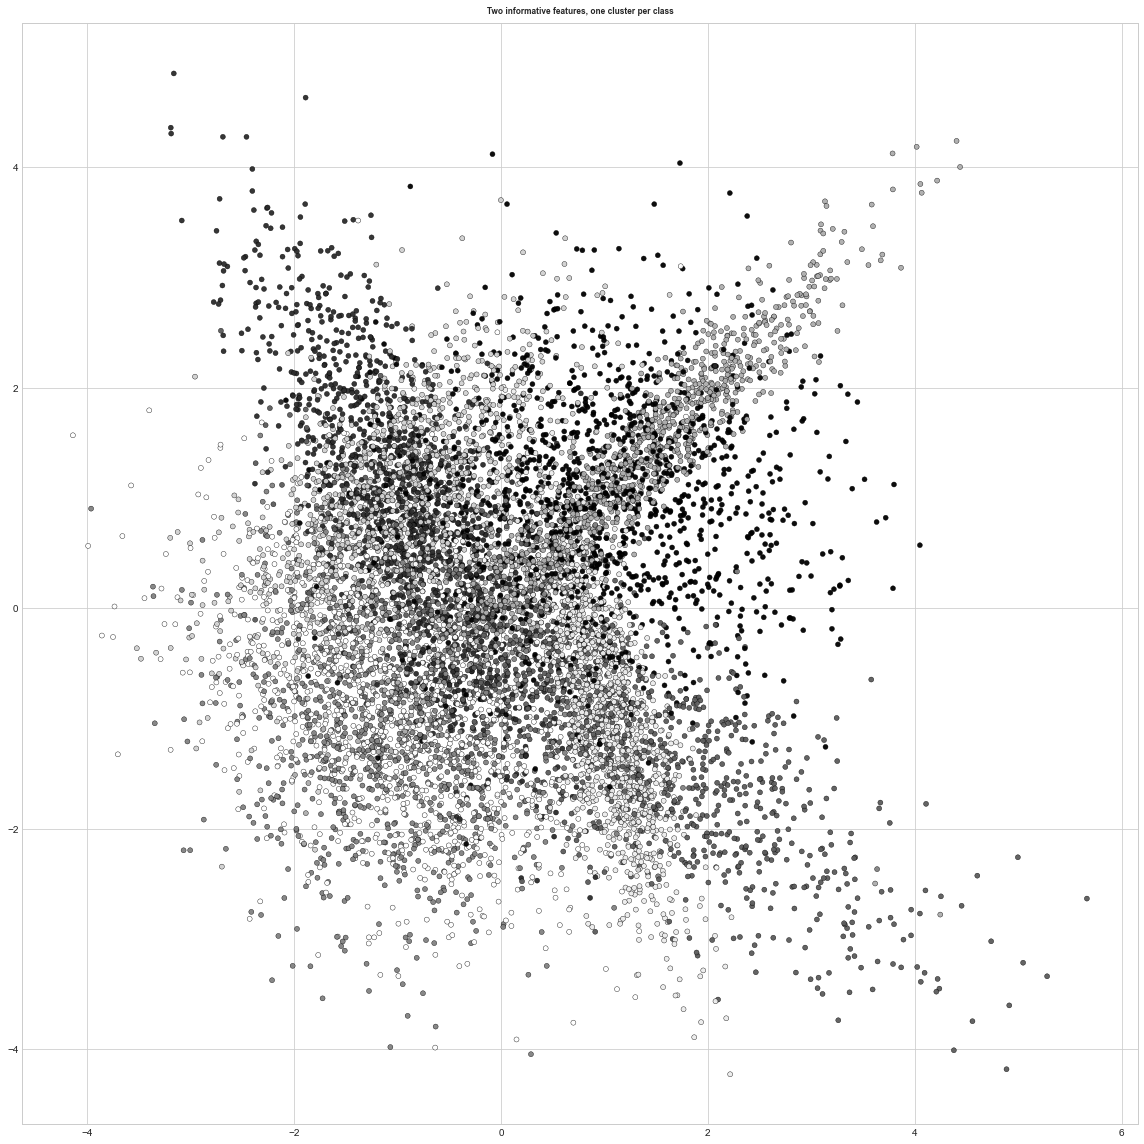

In [5]:
plt.figure(figsize=(16, 16))

plt.title("Two informative features, one cluster per class", fontsize="small")

sns.scatterplot(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k", alpha=0.95, palette="deep")

# Transform

In [6]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y = le.fit_transform(y) # y to categorical

In [7]:
# train, val = train_test_split(X, test_size=VALIDATION_SPLIT, stratify=X[[TARGET_FEATURE_NAME]], random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

# Features Configs

In [8]:
# TARGET_FEATURE_NAME = column_y
TARGET_FEATURE_LABELS = np.unique(y)
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [9]:
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)
print(np.unique(y, return_counts=True))

15
8
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([1244, 1248, 1249, 1258, 1258, 1238, 1249, 1256], dtype=int64))


# Models

In [10]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

In [11]:
def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

In [12]:
class MCDropout(keras.layers.AlphaDropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = MCDropout(rate = dropout_rate) #MCDropout layers.Dropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

In [13]:
def wide_deep_model(**kwargs):
    il = layers.Input(shape=(INPUT_SHAPE), name="input")
    x = layers.Dense(units=128, activation=ACTIVATION)(il)
    x1 = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x1)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT)(layers.Concatenate()([x, x1])) #AlphaDropout
    x = layers.Dense(units=64, activation=ACTIVATION)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units=NUM_CLASSES, activation="softmax", name="output")(x)

    model = tf.keras.Model([il], output)
    return model

In [14]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

In [15]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [16]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [17]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs


In [18]:
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features


def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [19]:
def build_models(models):
    for model in models:
        model.compile(
            optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
        )


In [20]:
def fit_models(models, historys, X_train, y_train, X_valid, y_valid):
    for model in models:
        history = model.fit(X_train, y_train,
                            validation_data=(X_valid, y_valid),
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[early_stopping, plateau,  # tensorboard_callback
                                       ],
                            shuffle=True,
                            verbose=VERBOSE,
                            )
        historys.append(history)


In [21]:
def evaluate_models(models, historys, X_test=X_test, y_test=y_test):
    for model, history in zip(models, historys):
        model.summary()
        _, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        print('Accuracy: %.2f' % (accuracy*100))
        plot_acc(pd.DataFrame(history.history))


In [22]:
def predict_models(models, X_test):
    predict_hat = np.zeros((1, 1))
    for model in models:
        predict_hat = predict_hat + model.predict(X_test, verbose=VERBOSE)
        # print(f'predict_hat: {predict_hat}')

    return predict_hat

# Build models

In [23]:
y_train_1_2 = y_train[(y_train <= 1)]
y_train_3_4_6_7 = y_train[(y_train > 1)]
X_train_1_2 = X_train[(y_train <= 1)]
X_train_3_4_6_7 = X_train[(y_train > 1)]

y_valid_1_2 = y_valid[(y_valid <= 1)]
y_valid_3_4_6_7 = y_valid[(y_valid > 1)]
X_valid_1_2 = X_valid[(y_valid <= 1)]
X_valid_3_4_6_7 = X_valid[(y_valid > 1)]

y_test_1_2 = y_test[(y_test <= 1)]
y_test_3_4_6_7 = y_test[(y_test > 1)]
X_test_1_2 = X_test[(y_test <= 1)]
X_test_3_4_6_7 = X_test[(y_test > 1)]

In [24]:
models = []
historys = []
models_1_2 = []
historys_1_2 = []
models_3_4_6_7 = []
historys_3_4_6_7 = []

In [25]:
model_MLP = MLP(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_MLP)


In [26]:
model_wide_deep = wide_deep_model()
models.append(model_wide_deep)
model_wide_deep_1_2 = wide_deep_model()
models_1_2.append(model_wide_deep_1_2)
model_wide_deep_3_4_6_7 = wide_deep_model()
models_3_4_6_7.append(model_wide_deep_3_4_6_7)

In [27]:
model_CrossNet = CrossNet(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_CrossNet)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 15)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 128)          2048        ['input[0][0]']                  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128)         512         ['dense_8[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_9 (Dense)                (None, 64)           8256        ['batch_normalization_8[0][

C:\Users\furyx\AppData\Local\Temp/ipykernel_17832/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


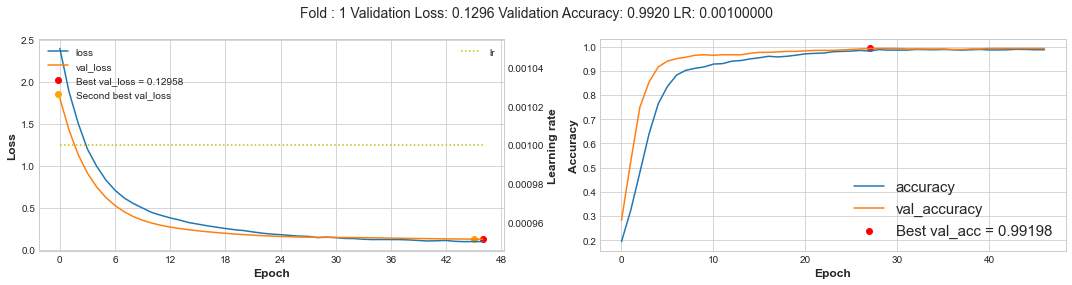

In [28]:
build_models(models=models_1_2)
fit_models(models=models_1_2, historys=historys_1_2, X_train=X_train_1_2,
           y_train=y_train_1_2, X_valid=X_valid_1_2, y_valid=y_valid_1_2)
evaluate_models(models=models_1_2, historys=historys_1_2,
                X_test=X_test_1_2, y_test=y_test_1_2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 15)]         0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 128)          2048        ['input[0][0]']                  
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128)         512         ['dense_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_13 (Dense)               (None, 64)           8256        ['batch_normalization_12[0]

C:\Users\furyx\AppData\Local\Temp/ipykernel_17832/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


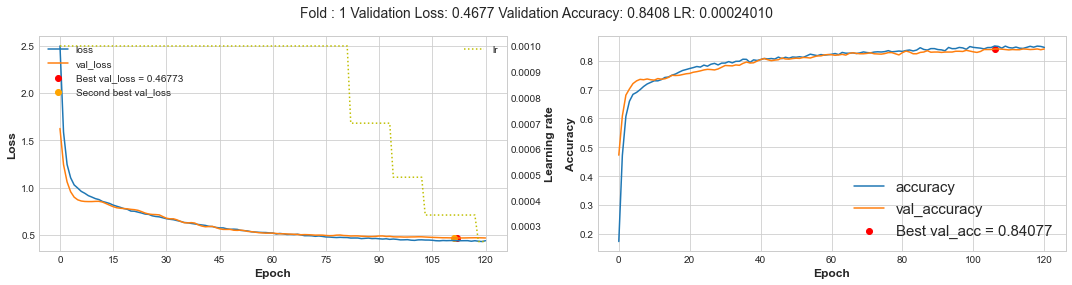

In [29]:
build_models(models=models_3_4_6_7)
fit_models(models=models_3_4_6_7, historys=historys_3_4_6_7, X_train=X_train_3_4_6_7,
           y_train=y_train_3_4_6_7, X_valid=X_valid_3_4_6_7, y_valid=y_valid_3_4_6_7)
evaluate_models(models=models_3_4_6_7, historys=historys_3_4_6_7,
                X_test=X_test_3_4_6_7, y_test=y_test_3_4_6_7)


Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block (DenseBlock)    multiple                  3840      
                                                                 
 dense_block_1 (DenseBlock)  multiple                  25216     
                                                                 
 dense_block_2 (DenseBlock)  multiple                  17024     
                                                                 
 dense_block_3 (DenseBlock)  multiple                  8512      
                                                                 
 output (Dense)              multiple                  520       
                                                                 
Total params: 55,112
Trainable params: 54,088
Non-trainable params: 1,024
_________________________________________________________________
Accuracy: 72.45
Model: "model"
________________________

C:\Users\furyx\AppData\Local\Temp/ipykernel_17832/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


Accuracy: 78.35
Model: "cross_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block_4 (DenseBlock)  multiple                  3840      
                                                                 
 dense_block_5 (DenseBlock)  multiple                  25216     
                                                                 
 dense_block_6 (DenseBlock)  multiple                  17024     
                                                                 
 dense_block_7 (DenseBlock)  multiple                  8512      
                                                                 
 dense_20 (Dense)            multiple                  240       
                                                                 
 concatenate_3 (Concatenate)  multiple                 0         
                                                                 
 batch_normalization_20 (Bat  multiple   

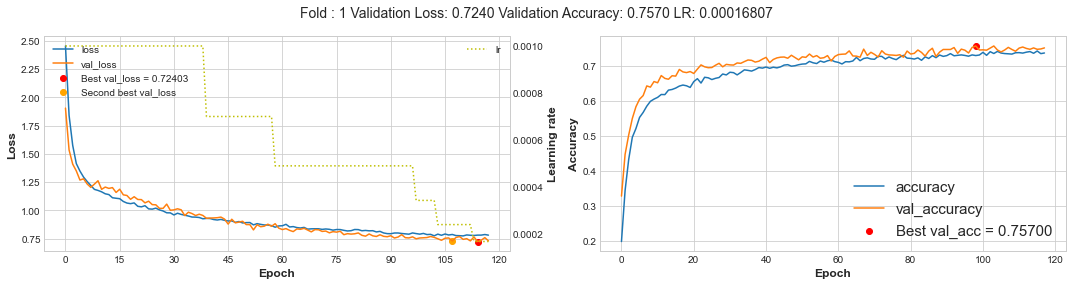

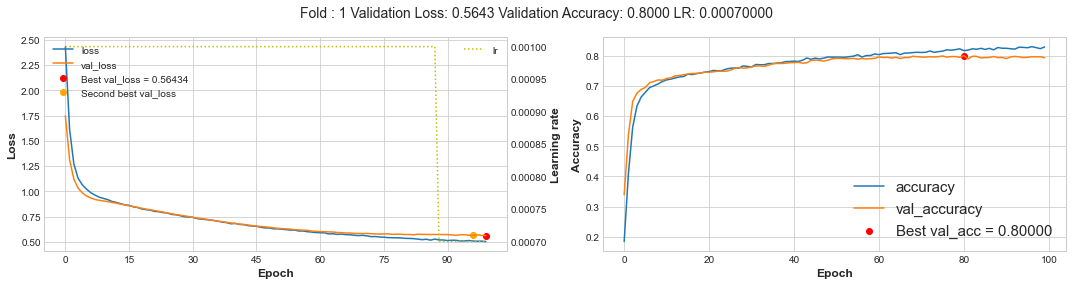

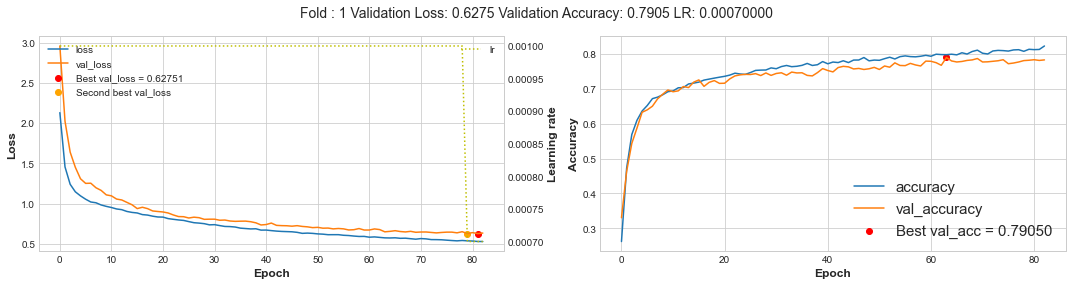

In [30]:
build_models(models=models)
fit_models(models=models, historys=historys, X_train=X_train,
           y_train=y_train, X_valid=X_valid, y_valid=y_valid)
evaluate_models(models=models, historys=historys,
                X_test=X_test, y_test=y_test)

In [31]:
preds_test = np.zeros((1, 1))
preds_test_1_2 = np.zeros((1, 1))
preds_test_3_4_6_7 = np.zeros((1, 1))

In [32]:
preds_test = predict_models(models = models, X_test = X_test)
preds_test_1_2 = predict_models(models = models_1_2, X_test = X_test)
preds_test_3_4_6_7 = predict_models(models = models_3_4_6_7, X_test = X_test)

In [33]:
results = np.argmax(preds_test, axis=1)
results_1_2 = np.argmax(preds_test_1_2, axis=1)
results_3_4_6_7 = np.argmax(preds_test_3_4_6_7, axis=1)

In [34]:
accuracy_score(y_test, results)

0.7655

In [35]:
accuracy_score(y_test, results_1_2)

0.251

In [36]:
accuracy_score(y_test, results_3_4_6_7)

0.6065

In [37]:
preds_test_all = preds_test + preds_test_1_2 + preds_test_3_4_6_7

In [38]:
preds_test_all[0]

array([1.26519245, 0.00579225, 2.98412509, 0.00937113, 0.01883   ,
       0.02728667, 0.62923733, 0.06016514])

In [39]:
accuracy_score(y_test, np.argmax(preds_test_all, axis=1))

0.7705

In [40]:
scores = []
# float step
for WEIGHT in np.arange(0.1, 8., 0.1):
    results_bag = []
    preds_hat = preds_test.copy()
    for e, val in enumerate(preds_hat):
        # print(f'{val}')
        val[0] += preds_test_1_2[e][0]/WEIGHT
        val[1] += preds_test_1_2[e][1]/WEIGHT
        val[2] += preds_test_3_4_6_7[e][2]/WEIGHT
        val[3] += preds_test_3_4_6_7[e][3]/WEIGHT
        val[4] += preds_test_3_4_6_7[e][4]/WEIGHT
        val[5] += preds_test_3_4_6_7[e][5]/WEIGHT
        val[6] += preds_test_3_4_6_7[e][6]/WEIGHT
        val[7] += preds_test_3_4_6_7[e][7]/WEIGHT
        results_bag.append(np.argmax(val, axis=0))

    scores.append(accuracy_score(y_test, results_bag))

for i, score in enumerate(scores):
    print(f'{i}, {score}')


0, 0.6905
1, 0.7385
2, 0.7595
3, 0.769
4, 0.7725
5, 0.774
6, 0.7725
7, 0.7735
8, 0.7715
9, 0.7715
10, 0.772
11, 0.773
12, 0.773
13, 0.7725
14, 0.772
15, 0.7725
16, 0.771
17, 0.7705
18, 0.77
19, 0.7715
20, 0.7715
21, 0.771
22, 0.771
23, 0.7705
24, 0.7705
25, 0.7705
26, 0.7705
27, 0.7705
28, 0.7705
29, 0.7705
30, 0.7705
31, 0.771
32, 0.771
33, 0.7705
34, 0.771
35, 0.771
36, 0.771
37, 0.7715
38, 0.771
39, 0.771
40, 0.771
41, 0.771
42, 0.771
43, 0.771
44, 0.771
45, 0.771
46, 0.771
47, 0.7705
48, 0.77
49, 0.77
50, 0.77
51, 0.77
52, 0.77
53, 0.77
54, 0.77
55, 0.77
56, 0.77
57, 0.77
58, 0.77
59, 0.77
60, 0.77
61, 0.7695
62, 0.77
63, 0.77
64, 0.77
65, 0.77
66, 0.7695
67, 0.7695
68, 0.7695
69, 0.7695
70, 0.7695
71, 0.7695
72, 0.7695
73, 0.7695
74, 0.7695
75, 0.7695
76, 0.7695
77, 0.7695
78, 0.7695


In [41]:
max(scores)

0.774

In [51]:
preds_test_1_2[0]

array([9.86979604e-01, 4.76256787e-07, 2.84166355e-03, 2.22539878e-03,
       4.02595289e-03, 1.35291787e-03, 1.50645885e-03, 1.06747402e-03])

In [54]:
preds_test_1_2[0][:-NUM_CLASSES+1]

array([0.9869796])

In [50]:
NUM_CLASSES

8

In [43]:
WEIGHT = 0.6
results_bag = []
preds_hat = preds_test.copy()
for e, val in enumerate(preds_hat):
    # print(f'{val}')
    val[0] += preds_test_1_2[e][0]/WEIGHT
    val[1] += preds_test_1_2[e][1]/WEIGHT
    for i in range(2, NUM_CLASSES, 1):
        val[i] += preds_test_3_4_6_7[e][i]/WEIGHT
    # val[2] += preds_test_3_4_6_7[e][2]/WEIGHT
    # val[3] += preds_test_3_4_6_7[e][3]/WEIGHT
    # val[4] += preds_test_3_4_6_7[e][4]/WEIGHT
    # val[5] += preds_test_3_4_6_7[e][5]/WEIGHT
    # val[6] += preds_test_3_4_6_7[e][6]/WEIGHT
    # val[7] += preds_test_3_4_6_7[e][7]/WEIGHT
    results_bag.append(np.argmax(val, axis=0))

accuracy_score(y_test, results_bag)

0.774

In [44]:
accuracy_score(y_test, results_bag)

0.774

In [45]:
results_1_2

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [46]:
# preds_test = models[0].predict(X_test[:1])

In [47]:
# preds_test = preds_test + preds_test

In [48]:
preds_test.shape

(2000, 8)

In [49]:
preds_test[0][1]

0.000758621479235444